### libs

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import gridspec

import numpy as np
import pandas as pd

from scipy.interpolate import UnivariateSpline

from pathlib import Path

### functions & initialization

In [2]:
def normalize_cluster(cluster):
    cluster['x'] *= R_norm
    cluster['y'] *= R_norm
    cluster['z'] *= R_norm

    cluster['vx'] *= V_norm
    cluster['vy'] *= V_norm
    cluster['vz'] *= V_norm

    cluster['M'] *= M_norm
    cluster['M_ini'] *= M_norm
    
    return cluster

In [3]:
def spherical_coords(cluster, density_cs, snapshot):
    xc, yc, zc = density_cs.iloc[snapshot, 1:4]
    vxc, vyc, vzc = density_cs.iloc[snapshot, 4:7]
    
    r = np.sqrt((cluster['x'] - xc) ** 2 + (cluster['y'] - yc) ** 2 + (cluster['z'] - zc) ** 2)
    phi = np.arctan2((cluster['y'] - yc), (cluster['x'] - xc))
    theta = np.arccos((cluster['z'] - zc) / r)
    
    vr = (cluster['vx'] - vxc) * np.cos(phi) * np.sin(theta) + \
         (cluster['vy'] - vyc) * np.sin(phi) * np.sin(theta) + \
         (cluster['vz'] - vzc) * np.cos(theta)
    return r, vr

In [4]:
def cluster_center_coords(cluster, density_cs, snapshot):
    xc, yc, zc = density_cs.iloc[snapshot, 1:4]
    vxc, vyc, vzc = density_cs.iloc[snapshot, 4:7]
    
    r = np.sqrt((cluster['x'] - xc) ** 2 + (cluster['y'] - yc) ** 2 + (cluster['z'] - zc) ** 2)
    
    alpha = np.arctan2(yc, xc)
    
    x_new =   np.cos(alpha) * (cluster['x'] - xc) + np.sin(alpha) * (cluster['y'] - yc)
    
    vx_new =   np.cos(alpha) * (cluster['vx'] - vxc) + np.sin(alpha) * (cluster['vy'] - vyc)
    vy_new = - np.sin(alpha) * (cluster['vx'] - vxc) + np.cos(alpha) * (cluster['vy'] - vyc)
    vz_new =   cluster['vz'] - vzc
    
    plt.hist(vx_new * abs(x_new) / x_new, bins=250, label=snapshot)
    plt.xlim(-30,30)
    plt.legend()
    plt.show()

    return r, vx_new

In [5]:
def get_filename(snapshot):
    snapstring = str(snapshot)
    while len(snapstring) < 6:
        snapstring = '0' + snapstring

    return snapstring + '.dat'

In [6]:
R_norm = 1.2262963200 #pc
V_norm = 4.587330615 #km/s
M_norm = 6.0e3 #Msun
T_norm = 0.261359 #million years
OUTPUT_DIR = Path('./../gamma=1.0/run-1.0-0.07-11/')

R_max = 100 #pc

In [7]:
files = ['000000.dat', 
         '000010.dat', 
         '000020.dat', 
         '000040.dat', 
         '000060.dat',
         '000100.dat', 
         '000150.dat', 
         '000200.dat', 
         '000250.dat']

In [8]:
names = np.array(['M', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M_ini', 'Z', 'Nan', 'Event',
                  'M_', 'Nan3', 'Nan4', 'Nan5', 'Nan6', 'Nan7', 'Nan8'])

In [9]:
v_in_shells, vx_in_shells = pd.DataFrame(), pd.DataFrame()
v_in_shells['r'] = np.linspace(0, R_max, 151)[1:]
vx_in_shells['r'] = np.linspace(0, R_max, 151)[1:]

### main loop

In [10]:
for file in files:
    cluster = pd.read_csv(OUTPUT_DIR / file, index_col=0, delimiter='\s+', header=3, names=names)
    cluster = normalize_cluster(cluster)
    density_cs = pd.read_csv(OUTPUT_DIR / 'def-dc.dat', delimiter='\s+', index_col=0, header=None)
    snapshot = int(file.split('.')[0])
    
    cluster['r'], cluster['vr'] = spherical_coords(cluster, density_cs, snapshot)
    cluster_center = cluster[cluster['r'] < R_max].copy()
    
    r_i_1 = 0
    v_in_shell = []
    
    for r_i in v_in_shells['r']:
        dr_stars = cluster_center[(cluster_center['r']<=r_i) & (cluster_center['r']>r_i_1)]
        N = len(dr_stars)
        vr_sum = dr_stars['vr'].sum()
        if N > 0:
            v_in_shell.append(vr_sum / N)
        else: v_in_shell.append(0)
        r_i_1 = r_i
        
    v_in_shells[f'{snapshot}'] = v_in_shell

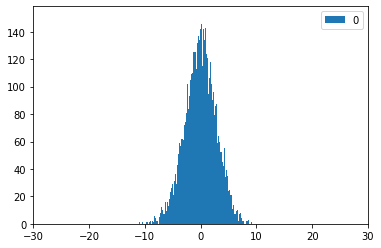

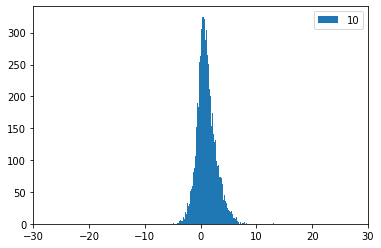

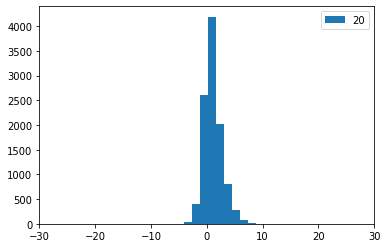

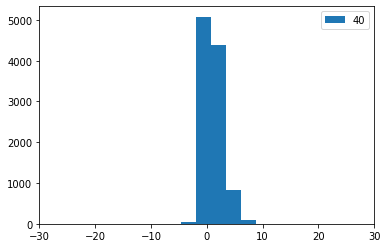

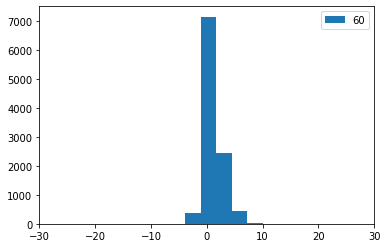

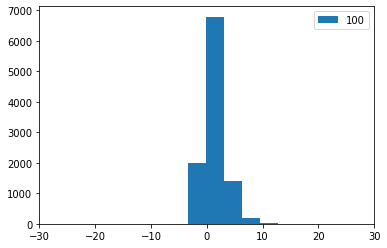

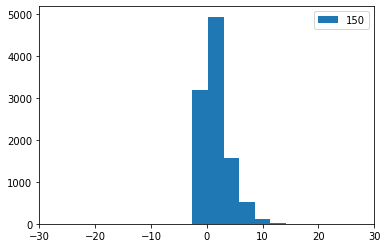

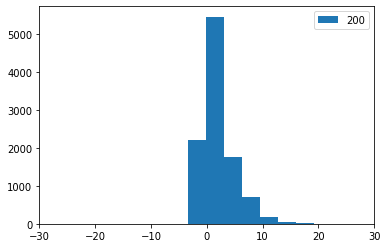

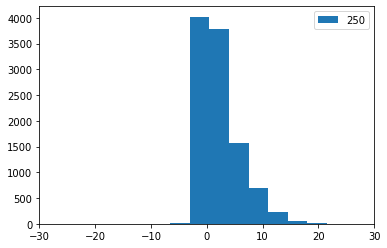

In [14]:
for file in files:
    cluster = pd.read_csv(OUTPUT_DIR / file, index_col=0, delimiter='\s+', header=3, names=names)
    cluster = normalize_cluster(cluster)
    density_cs = pd.read_csv(OUTPUT_DIR / 'def-dc.dat', delimiter='\s+', index_col=0, header=None)
    snapshot = int(file.split('.')[0])
    
    cluster['r'], cluster['vx_'] = cluster_center_coords(cluster, density_cs, snapshot)
    cluster_center = cluster[cluster['r'] < R_max].copy()
    
    r_i_1 = 0
    v_in_shell = []
    
    for r_i in v_in_shells['r']:
        dr_stars = cluster_center[(cluster_center['r']<=r_i) & (cluster_center['r']>r_i_1)]
        N = len(dr_stars)
        vx_sum = dr_stars['vx_'].sum()
        if N > 0:
            v_in_shell.append(vx_sum / N)
        else: v_in_shell.append(0)
        r_i_1 = r_i
        
    vx_in_shells[f'{snapshot}'] = v_in_shell

### plots

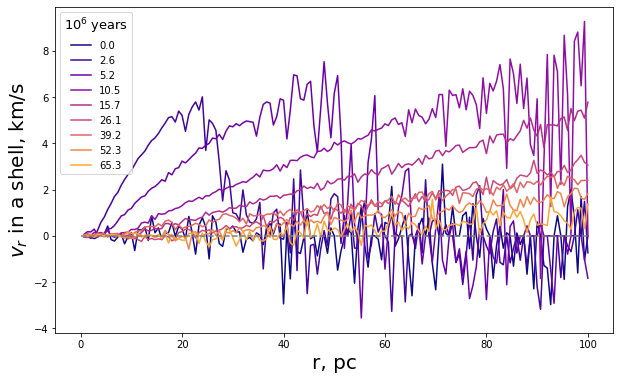

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
color=iter(cm.plasma(np.linspace(0, 1, 11)))

for snap in v_in_shells.columns[1:]:
    c=next(color)
    ax.plot(v_in_shells['r'], v_in_shells[f'{snap}'], c=c, label=np.round(density_cs.iloc[int(snap),0], 1))
ax.plot([0,100], [0,0], ls='--', c='grey')


ax.set_xlabel('r, pc', fontsize=20)
ax.set_ylabel(r'$v_r$ in a shell, km/s', fontsize=20)
ax.legend(title=r'$10^6$ years', title_fontsize=13, fontsize=10)
#plt.savefig('vr_in_shells_in_time.pdf')

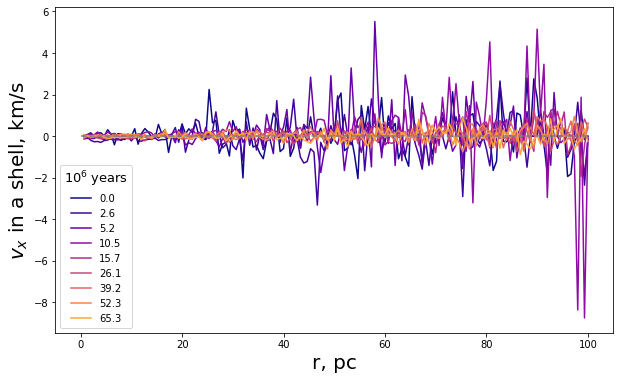

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
color=iter(cm.plasma(np.linspace(0, 1, 11)))

for snap in vx_in_shells.columns[1:]:
    c=next(color)
    ax.plot(vx_in_shells['r'], vx_in_shells[f'{snap}'], c=c, label=np.round(density_cs.iloc[int(snap),0], 1))
ax.plot([0,100], [0,0], ls='--', c='grey')

ax.set_xlabel('r, pc', fontsize=20)
ax.set_ylabel(r'$v_x$ in a shell, km/s', fontsize=20)
ax.legend(title=r'$10^6$ years', title_fontsize=13, fontsize=10)
#plt.savefig('vr_in_shells_in_time.pdf')

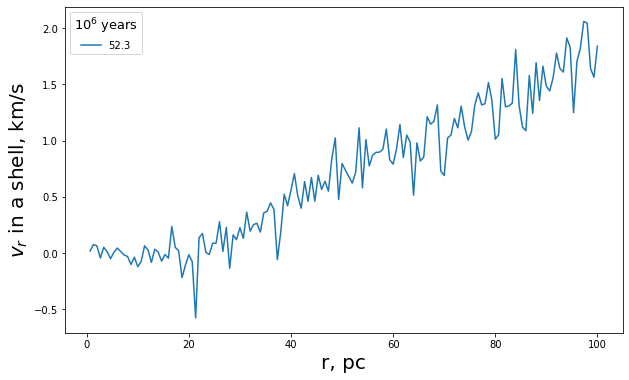

In [17]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(v_in_shells['r'], v_in_shells[f'{200}'], label=np.round(density_cs.iloc[int(200),0], 1))
ax.legend(title=r'$10^6$ years', title_fontsize=13, fontsize=10)
ax.set_xlabel('r, pc', fontsize=20)
ax.set_ylabel(r'$v_r$ in a shell, km/s', fontsize=20)
plt.savefig('vr_in_shells_52my.pdf')

### saving the table

In [18]:
# snapshots = list(map(int, list(v_in_shells.columns)[1:]))

In [19]:
# v_in_shells.columns = ['r'] + list(np.round(density_cs.iloc[snapshots, 0], 1))

In [20]:
# v_in_shells.to_csv('vr_in_shell.csv', sep=' ', index=False)

### acceleration calculation

In [21]:
density_cs = pd.read_csv(OUTPUT_DIR / 'def-dc.dat', delimiter='\s+', index_col=0, header=None)

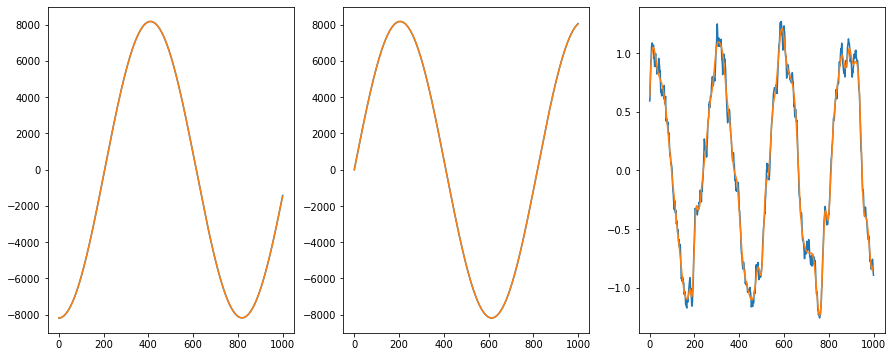

In [22]:
coord_spline_x = UnivariateSpline(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,1], s=3.5)
coord_spline_y = UnivariateSpline(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,2], s=3.5)
coord_spline_z = UnivariateSpline(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,3], s=3.5)

t_range = np.arange(0, 1000, 1)

fig = plt.figure(figsize=(15, 6))

spec = gridspec.GridSpec(ncols=3, nrows=1)
ax = fig.add_subplot(spec[0])
ax.plot(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,1])
ax.plot(t_range, coord_spline_x(t_range))

ax = fig.add_subplot(spec[1])
ax.plot(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,2])
ax.plot(t_range, coord_spline_y(t_range))

ax = fig.add_subplot(spec[2])
ax.plot(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,3])
ax.plot(t_range, coord_spline_z(t_range))

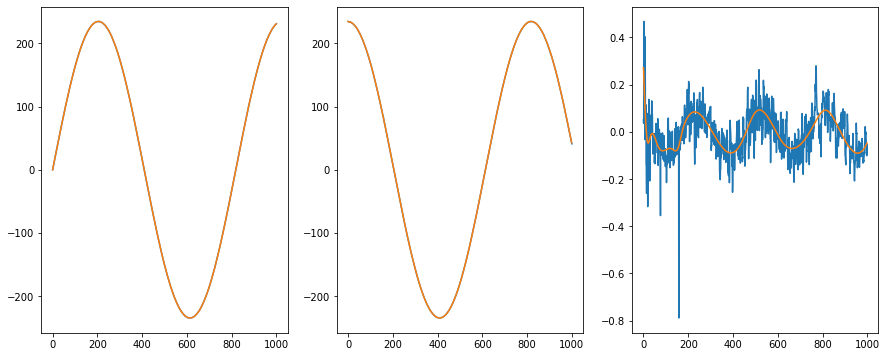

In [23]:
vel_spline_x = UnivariateSpline(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,4], s=3.5)
vel_spline_y = UnivariateSpline(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,5], s=3.5)
vel_spline_z = UnivariateSpline(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,6], s=5)

t_range = np.arange(0, 1000, 1)

fig = plt.figure(figsize=(15, 6))

spec = gridspec.GridSpec(ncols=3, nrows=1)
ax = fig.add_subplot(spec[0])
ax.plot(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,4])
ax.plot(t_range, vel_spline_x(t_range))

ax = fig.add_subplot(spec[1])
ax.plot(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,5])
ax.plot(t_range, vel_spline_y(t_range))

ax = fig.add_subplot(spec[2])
ax.plot(density_cs.iloc[:,0] / T_norm, density_cs.iloc[:,6])
ax.plot(t_range, vel_spline_z(t_range))

In [29]:
snapshot = 100

In [30]:
cluster = pd.read_csv(OUTPUT_DIR / get_filename(snapshot), 
                          index_col=0, delimiter='\s+', header=3, names=names)
cluster = normalize_cluster(cluster)

cluster_prev = pd.read_csv(OUTPUT_DIR / get_filename(snapshot - 1), 
                               index_col=0, delimiter='\s+', header=3, names=names)
cluster_prev = normalize_cluster(cluster_prev)

cluster_post = pd.read_csv(OUTPUT_DIR / get_filename(snapshot + 1), 
                               index_col=0, delimiter='\s+', header=3, names=names)
cluster_post = normalize_cluster(cluster_post)

In [31]:
# dvxc, dvyc, dvzc = density_cs.iloc[snapshot + 1, 4:7] - density_cs.iloc[snapshot - 1, 4:7]
dvxc = vel_spline_x(t_range)[snapshot + 1] - vel_spline_x(t_range)[snapshot - 1]
dvyc = vel_spline_y(t_range)[snapshot + 1] - vel_spline_y(t_range)[snapshot - 1]
dvzc = vel_spline_z(t_range)[snapshot + 1] - vel_spline_z(t_range)[snapshot - 1]

acc_x = (cluster_post['vx'] - cluster_prev['vx'] - dvxc) / (2 * T_norm) 
acc_y = (cluster_post['vy'] - cluster_prev['vy'] - dvyc) / (2 * T_norm) 
acc_z = (cluster_post['vz'] - cluster_prev['vz'] - dvzc) / (2 * T_norm) 

acceleration = np.sqrt(acc_x ** 2 + acc_y ** 2 +acc_z ** 2) / (2 * T_norm) 

In [34]:
xc = coord_spline_x(t_range)[snapshot] 
yc = coord_spline_y(t_range)[snapshot]
zc = coord_spline_z(t_range)[snapshot]
# xc, yc, zc = density_cs.iloc[snapshot, 1:4]

alpha = np.arctan2(yc, xc)

x_ = np.cos(alpha) * (cluster['x'] - xc) + np.sin(alpha) * (cluster['y'] - yc)
y_ = - np.cos(alpha) * (cluster['x'] - xc) + np.sin(alpha) * (cluster['y'] - yc)
z_ = cluster['z'] - zc

acc_x_ = np.cos(alpha) * acc_x + np.sin(alpha) * acc_x
acc_y_ = - np.cos(alpha) * acc_y + np.sin(alpha) * acc_y
acc_z_ = acc_z

<AxesSubplot:>

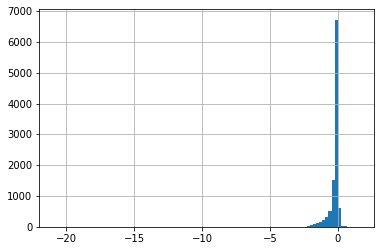

In [35]:
(acc_z_ * z_ / abs(z_)).hist(bins=100)